In [1]:
# Imports

import networkx as nx
import numpy as np
import pandas as pd
import numpy.random as random

import matplotlib.pyplot as plt

from IPython.display import Image
from pandas import Series, DataFrame


%matplotlib inline

## <center> 1. Network Description </center>


####     Network is a 6-hop directed group VK network rooted at node 'club132' ("НИУ ВШЭ (ГУ-ВШЭ)", http://vk.com/club132). Network edges arel links between groups. <br><br>     After collecting raw network (167227 nodes) small preprocessing was accomplished: <br> a) all nodes with out-degree < 3 were removed; <br> b) all nodes with degree == 0 were removed; <br> c) all nodes unreachable from 'club132' were removed. As result about 23 000 nodes remained.

In [2]:
# Reading graph
G = nx.read_graphml('groups.graphml', node_type=int)

In [112]:
# Precomputing some metrics

betweeness = nx.betweenness_centrality(G)
be = Series(index=betweeness.keys())
for i in be.index:
    be.loc[i] = betweeness[i]
be.to_csv("metrics/betweeness.csv")

closeness = nx.closeness_centrality(G)
cl = Series(index=closeness.keys())
for i in cl.index:
    cl.loc[i] = closeness[i]
cl.to_csv("metrics/closeness.csv")

eig = nx.eigenvector_centrality(G)
ei = Series(index=eig.keys())
for i in ei.index:
    ei.loc[i] = eig[i]
ei.to_csv("metrics/eig.csv")

prank = nx.pagerank(G)
pr = Series(index=prank.keys())
for i in pr.index:
    pr.loc[i] = prank[i]
pr.to_csv("metrics/prank.csv")

In [3]:
# Reading precomputed metrics

betweeness = pd.read_csv("metrics/betweeness.csv", index_col=0, header=None)
betweeness = Series(betweeness.ix[:, 1])
betweeness.sort(ascending = False)

closeness = pd.read_csv("metrics/closeness.csv", index_col=0, header=None)
closeness = Series(closeness.ix[:, 1])
closeness.sort(ascending = False)

eig = pd.read_csv("metrics/eig.csv", index_col=0, header=None)
eig = Series(eig.ix[:, 1])
eig.sort(ascending = False)

prank = pd.read_csv("metrics/prank.csv", index_col=0, header=None)
prank = Series(prank.ix[:, 1])
prank.sort(ascending = False)

count    2.240000e+04
mean     2.396461e-04
std      1.121863e-03
min      0.000000e+00
25%      4.983129e-10
50%      2.232026e-05
75%      1.404036e-04
max      5.915835e-02
Name: 1, dtype: float64

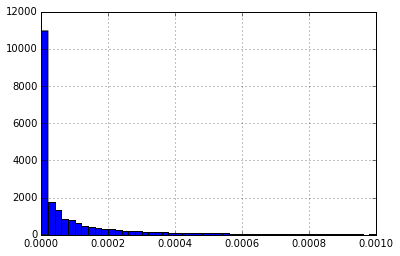

In [4]:
# Betweeness distribution
betweeness.hist(bins=50, range=(0, 0.001));
betweeness.describe()

count    22400.000000
mean         0.124465
std          0.049864
min          0.000000
25%          0.124125
50%          0.139257
75%          0.152048
max          0.221397
Name: 1, dtype: float64

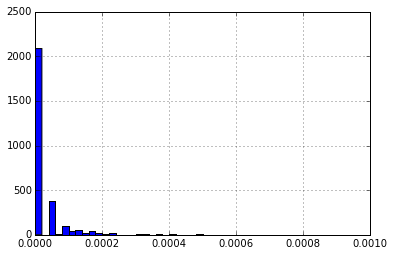

In [5]:
# Closeness distribution
closeness.hist(bins=50, range=(0, 0.001));
closeness.describe()

count    2.240000e+04
mean     2.277227e-04
std      6.677798e-03
min      6.749108e-14
25%      1.950372e-08
50%      1.153693e-07
75%      5.712188e-07
max      2.089629e-01
Name: 1, dtype: float64

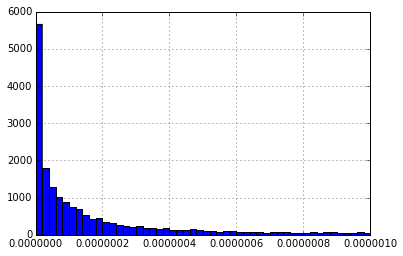

In [6]:
# Eigenvector centrality distribution
eig.hist(bins=50, range=(0, 1e-6));
eig.describe()

count    22400.000000
mean         0.000045
std          0.000053
min          0.000009
25%          0.000017
50%          0.000028
75%          0.000051
max          0.001291
Name: 1, dtype: float64

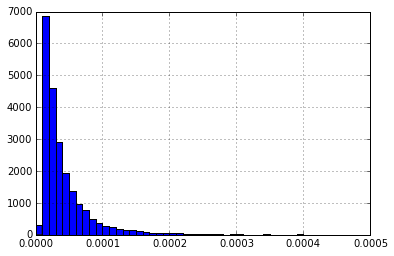

In [7]:
# PageRank distribution
prank.hist(bins=50, range=(0, 5e-4));
prank.describe()

count    22400.000000
mean         9.699018
std         11.936321
min          1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        213.000000
dtype: float64

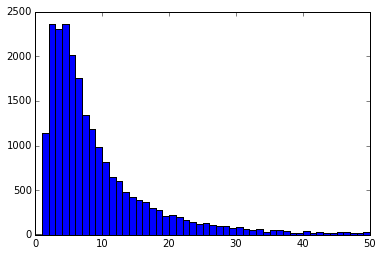

In [8]:
# Degree distribution
deg = Series(G.degree())
plt.hist(deg, bins=50, range=(0, 50));
deg.describe()

In [9]:
# SCC sizes: we have one Gigant SCC and a many veri little scc.
scc = nx.strongly_connected_components(G)
sorted(list(map(lambda x: len(x), scc)), reverse=True)[0:10]

[19590, 15, 12, 10, 8, 7, 6, 6, 6, 6]

In [10]:
# Merging scc into single nodes and saving into file for visualizing in Gephi
scc_net = nx.condensation(G)
mems = nx.get_node_attributes(scc_net, 'members')

# Setting nodes sizes for visualization
nodes = scc_net.nodes()
def sz(x):
    if x > 100:
        return 10
    if x > 10:
        return 5
    if x > 5:
        return 2.5
    return 1        
sizes = dict(zip(nodes, map(lambda x: sz(len(mems[x])), nodes)))
scc_net = nx.DiGraph(scc_net.edges())
nx.set_node_attributes(scc_net, 'Size', sizes)
nx.write_gml(scc_net, 'scc_net.gml')

In [11]:
# SCC sizes: One GCC and lots of small ones(about 2500)
Series(dict(zip(nodes, map(lambda x: len(mems[x]), nodes)))).value_counts()

1        2292
2         120
3          28
4          13
5          12
6           5
19590       1
15          1
7           1
12          1
10          1
8           1
dtype: int64

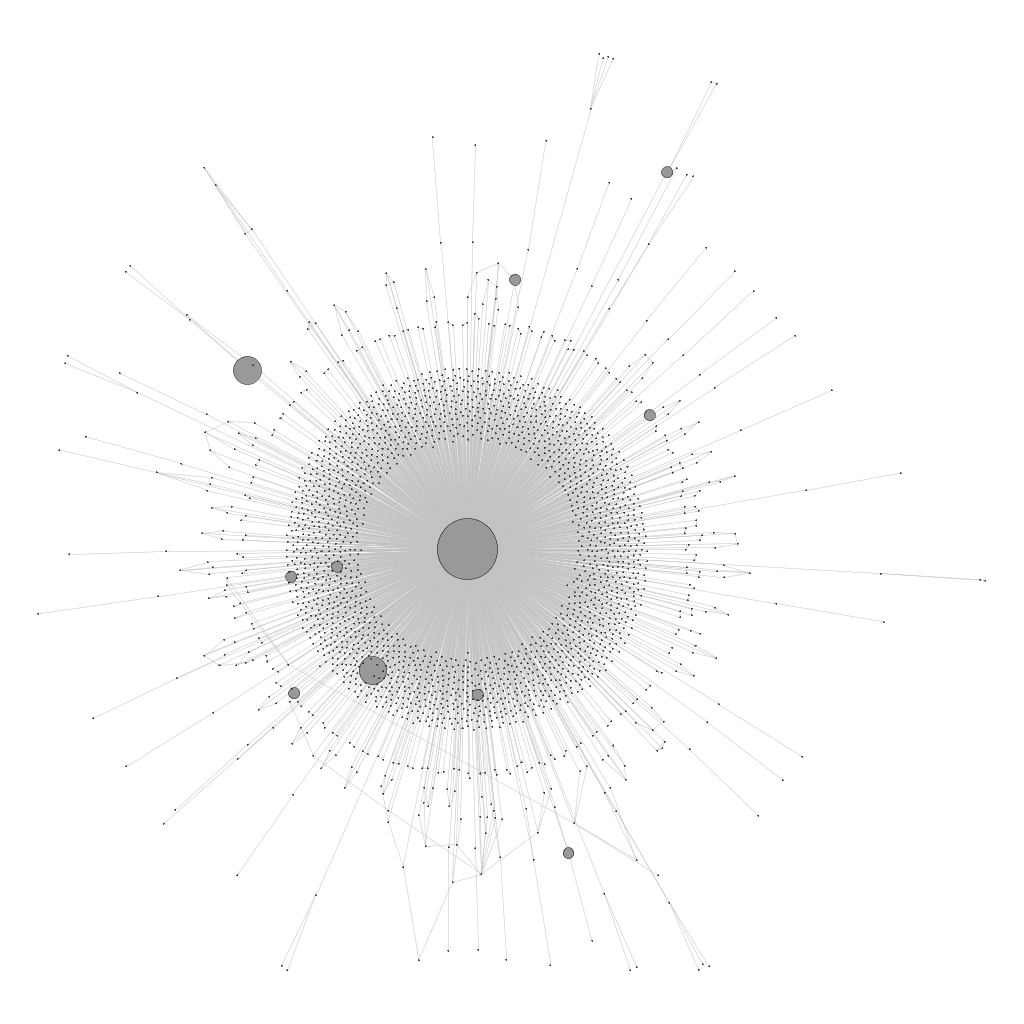

In [12]:
# SCC network produced in Gephi
Image(filename='net.png')

In [13]:
# So we have several node metrics and partitioning on SCC.
# In the next section we'l try to use this data for developing best strategy.

### <center>2. SIR-based epidemic model</center>

In [14]:
class SIR:    
    
    
    def __init__(self, G, inf_min, inf_max, beta):
        self.G = G
        self.inf_min = inf_min
        self.inf_max = inf_max              
        self.beta = beta
        self.S = None
        self.I = None
        self.R = None
        self.steps_infected = None
        
        
    def step(self):        
        I = set()               
        for u in self.I:    
            
            # epidemic propogation
            for v in G.neighbors(u):
                if v not in self.S:
                    continue
                else:
                    if random.random() < self.beta:
                        self.S.remove(v)
                        self.steps_infected[v] = random.random_integers(self.inf_min, self.inf_max)
                        I.add(v)        
            
            # epidemic recession
            self.steps_infected[u] -= 1
            if self.steps_infected[u] == 0:
                self.R.add(u)
            else:
                I.add(u)        
        self.I = I
        
    
    def run(self, I0, R0, treatment_cost):
        self.S = set(G.nodes()).difference(I0.union(R0))                      
        self.I = set(I0)
        self.R = set(R0)
        self.steps_infected = dict(zip(I0, random.random_integers(self.inf_min, self.inf_max, size=len(I0))))  
                
        cost = 0
        while(len(self.I) != 0):            
            cost += treatment_cost * len(self.I)
            self.step()
        return cost
        
        
    def __str__(self):
        return "S: %d I: %d R: %d" % (len(self.S), len(self.I), len(self.R))

In [91]:
class Strategy:    
    
    def __init__(self, G, betweeness, closeness, eig, prank):
        
        self.G = G
        
        # degrees
        self.deg = Series(G.degree())
        self.deg.sort(ascending=False)
        self.in_deg = Series(G.in_degree())
        self.in_deg.sort(ascending=False)
        self.out_deg = Series(G.out_degree())
        self.out_deg.sort(ascending=False)
        
        # betweeness, closeness, eig and prank
        self.be = betweeness   
        self.cl =  closeness
        self.ei = eig
        self.pr = prank
        
        # GCC
        scc = list(nx.strongly_connected_components(G))
        scc = sorted(scc, key=len, reverse=True)
        self.gcc = set(scc[0])
        
        
    def random(self, n):
        R0 = set(random.choice(G.nodes(), n))
        return(R0)        
        
        
    def degree(self, n):
        R0 = set(self.deg.index[0:n])
        return(R0)
    
    
    def in_degree(self, n):
        R0 = set(self.in_deg.index[0:n])
        return(R0)
    
    
    def out_degree(self, n):
        R0 = set(self.out_deg.index[0:n])
        return(R0)
    
    
    def betweeness(self, n):
        R0 = set(self.be.index[self.G.number_of_nodes() - n:])
        return(R0)
    
    
    def closeness(self, n):
        R0 = set(self.cl.index[0:n])
        return(R0)
    
    
    def eig(self, n):
        R0 = set(self.ei.index[0:n])
        return(R0)
    
    
    def PageRank(self, n):
        R0 = set(self.pr.index[0:n])
        return(R0)
    
    
    def SCC(self, n):
        
        # GCC
        gcc = self.gcc
                        
        # Getting most virulent bridges in GCC
        others = set(G.nodes()).difference(gcc)
        bridges_out = {}
        for u in gcc:
            victims_out = others.intersection(G.neighbors(u))
            if len(victims_out) == 0:
                continue
            bridges_out[u] = victims_out
        bridges_gcc = Series(index=bridges_out, data=list(map(lambda x: len(bridges_out[x]), bridges_out)))
        bridges_gcc.sort(ascending=False)        
        
        # Getting most virulent bridges not in GCC
        others = set(G.nodes()).difference(gcc)
        bridges_out = {}
        for u in others:
            victims_out = others.intersection(G.neighbors(u))
            if len(victims_out) == 0:
                continue
            bridges_out[u] = victims_out
        bridge_others = Series(index=bridges_out, data=list(map(lambda x: len(bridges_out[x]), bridges_out)))
        bridge_others.sort(ascending=False)       
        
        
        # Getting number of nodes to be vaccinated in GCC and not in GCC
        num_gcc = len(bridges_gcc)
        num_others = len(bridge_others)        
        r_others = np.floor(n * num_others / (num_others + num_gcc))
        r_gcc = n - r_others                
        
        # nodes for treatment
        R0 = set()
        R0.update(bridges_gcc.index[0:r_gcc])
        R0.update(bridge_others.index[0:r_others])        
        
        return(R0)    

In [92]:
class Simulator:
    
    def __init__(self, seed, G, strategy, inf_min, inf_max, beta, treat_cost, vac_cost):
        self.seed = seed
        self.G = G
        self.sir = SIR(G, inf_min, inf_max, beta)
        self.strategy = strategy
        self.treat_cost = treat_cost
        self.vac_cost = vac_cost
        

    def test_vac(self, vac_fun, times, num_vac, num_inf):
        '''Computes cost for given vaccination.'''
        
        random.seed(self.seed)
        costs = np.empty(times, dtype=np.double)                      
        # infected nodes                
        for i in range(times):
            print(i, end='\r')
            
            # nodes for vaccination
            R0 = vac_fun(num_vac)
            
            # infected nodes
            vulnerable = list(set(G.nodes()).difference(R0))
            I0 = set(random.choice(vulnerable, num_inf))           
            
            cost = self.sir.run(I0, R0, self.treat_cost)
            cost += len(R0) * self.vac_cost
            costs[i] = cost / 1e6
            
        return(costs)
    
    
    def test_no_vac(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.random, times, 0, num_inf)
    
                        
    def test_random(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.random, times, num_vac, num_inf)
    
    
    def test_degree(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.degree, times, num_vac, num_inf)
    
    
    def test_in_degree(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.in_degree, times, num_vac, num_inf)
    
    
    def test_out_degree(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.out_degree, times, num_vac, num_inf)
    
    
    def test_betweeness(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.betweeness, times, num_vac, num_inf)
    
    
    def test_closeness(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.closeness, times, num_vac, num_inf)
    
    
    def test_eig(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.eig, times, num_vac, num_inf)
    
    
    def test_prank(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.PageRank, times, num_vac, num_inf)            
    
    
    def test_scc(self, times, num_vac, num_inf):
        return self.test_vac(self.strategy.SCC, times, num_vac, num_inf)    

### <center>3. Simulation and Strategy Comparasion.</center>

In [93]:
# Simulation settings

seed = 1
strategy = Strategy(G, betweeness, closeness, eig, prank)

# inf_min - minimal number of days being infected
# inf_max - maximal number of days being infected
# beta - probability of disease transmission
sim = Simulator(seed, G, strategy, inf_min=3, inf_max=7, beta=0.4, treat_cost=120, vac_cost=500)

max_num_vac = G.number_of_nodes() / 10  # maximal number of nodes to be vaccinated
num_inf = 10                            # number of infected nodes( nodes are chosen randomly)
times = 100                             # number of simulations for each strategy

In [94]:
def test_vac_sizes(vac_fun, times, max_num_vac, num_inf):
    vac_sizes=np.round(max_num_vac * np.arange(0, 105, 5) / 100)
    res = np.empty(len(vac_sizes))
    for i in range(len(vac_sizes)):
        num_vac = vac_sizes[i]
        res[i] = np.median(vac_fun(times, num_vac, num_inf))
    return(res)        

In [95]:
# Getting vaccination results for all strategies

strategies=['no', 'random', 'degee', 'in-degree', 'out-degree', 'betweeness', 'closeness', 'eig', 'PageRank', 'SCC']
strategies_funs=[sim.test_no_vac, sim.test_random, sim.test_degree, sim.test_in_degree, sim.test_out_degree,
                 sim.test_betweeness, sim.test_closeness, sim.test_eig, sim.test_prank, sim.test_scc]
vac_results = DataFrame(index=np.arange(0, 105, 5), columns=strategies)

In [96]:
for i in range(len(strategies)):
    print(strategies[i] + '\n')
    vac_results.ix[:, strategies[i]] = test_vac_sizes(strategies_funs[i],
                                                      times=times, max_num_vac=max_num_vac, num_inf = num_inf)
    

no

random

degee

in-degree

out-degree

betweeness

closeness

eig

PageRank

SCC



In [97]:
vac_results

,no,random,degee,in-degree,out-degree,betweeness,closeness,eig,PageRank,SCC
0,12.98646,12.98646,12.98646,12.98646,12.98646,12.98646,12.98646,12.98646,12.98646,12.98646
5,12.98646,12.96602,12.50114,12.60980,12.47060,12.98612,12.72842,12.92906,12.63980,12.48350
10,12.98646,12.92883,12.14596,12.26368,12.01570,12.97294,12.55174,12.84088,12.33592,12.13552
15,12.98646,12.87583,11.77032,11.96766,11.64324,12.96876,12.41466,12.74394,12.08448,11.92200
20,12.98646,12.84638,11.49038,11.73530,11.40728,12.95450,12.30458,12.73274,11.80436,11.71364
25,12.98646,12.83049,11.21116,11.49184,11.17438,12.97612,12.17896,12.64846,11.55766,11.49838
30,12.98646,12.80369,10.88286,11.32728,10.86312,12.95094,12.04164,12.56946,11.32830,11.36958
35,12.98646,12.77228,10.64096,11.10512,10.57244,12.94958,11.89592,12.49364,11.13902,11.23298
40,12.98646,12.71515,10.40194,10.88794,10.29796,12.94714,11.77048,12.42388,10.91818,11.05960
45,12.98646,12.67889,10.15584,10.73304,10.06062,12.93012,11.66922,12.33120,10.76874,10.92972


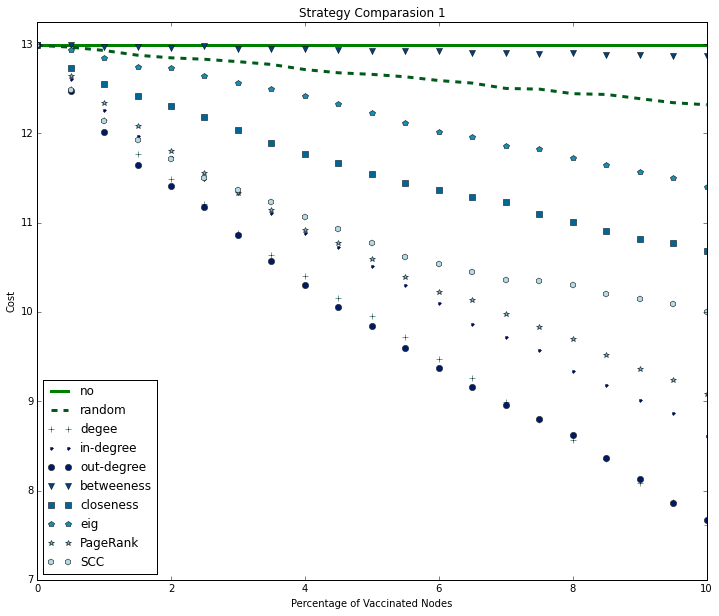

In [104]:
# Plotting all results together

plt.figure(figsize=(12, 10))
markers = ['-', '--', '+', '.', 'o', 'v', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
colormap = plt.cm.ocean
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(strategies))])

for i in range(len(strategies)):
    plt.plot(vac_results.index / 10, vac_results.ix[:, strategies[i]], markers[i], linewidth=3)
plt.legend(strategies, loc='best')
plt.ylim(7, 13.25)
plt.ylabel('Cost')
plt.xlabel('Percentage of Vaccinated Nodes')
plt.title('Strategy Comparasion 1')
plt.show()

#### Results show that degree is the metric of choice. Though we may see that PageRank also is a good metric. Strategy based on SCC is competitive than amount of vaccinated people is less than 1 %. Surprisingly betweeness is worse than random choice of nodes.